# Univariate Analysis

**Purpose:** Analyze each variable individually to understand distributions, patterns, and characteristics.

**Steps:**
1. Identify variable types (categorical vs numerical)
2. Analyze target variables
3. Analyze continuous features
4. Analyze categorical features

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)

## Load Database

In [2]:
# Connect to database and load full dataset
conn = sqlite3.connect('../databases/nhanes_1st.db')
df = pd.read_sql_query('SELECT * FROM raw_dataset', conn)
conn.close()
print(f"Dataset shape: {df.shape}")

Dataset shape: (34097, 29)


In [3]:
# Identify variable types: Categorical vs Numerical
print("="*80)
print("VARIABLE TYPE IDENTIFICATION")
print("="*80)

# Define target variables (excluded from feature analysis)
target_columns = [
    'has_cardiovascular_disease',
    'high_waist_circumference', 'high_triglycerides_mg_dl', 'low_hdl_mg_dl', 
    'high_blood_pressure', 'high_glucose_mg_dl',
    'kidney_acr_mg_g', 'liver_alt_U_L'
]

# Get feature columns (exclude targets)
feature_columns = [col for col in df.columns if col not in target_columns]

# Identify numerical vs categorical using pandas
numeric_features = df[feature_columns].select_dtypes(include=[np.number])
numerical_cols = [col for col in numeric_features.columns if df[col].nunique() > 10]
categorical_cols = [col for col in feature_columns if col not in numerical_cols]

# Summary
print(f"\nTotal Features: {len(feature_columns)}")
print(f"  - Numerical (Continuous): {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")
print(f"  - Target Variables: {len(target_columns)}")

print(f"\n📊 Numerical Variables ({len(numerical_cols)}):")
for col in sorted(numerical_cols):
    print(f"  • {col}")

print(f"\n📋 Categorical Variables ({len(categorical_cols)}):")
for col in sorted(categorical_cols):
    print(f"  • {col} ({df[col].nunique()} unique values)")

print(f"\n🎯 Target Variables ({len(target_columns)}):")
for col in sorted(target_columns):
    print(f"  • {col}")

VARIABLE TYPE IDENTIFICATION

Total Features: 23
  - Numerical (Continuous): 18
  - Categorical: 5
  - Target Variables: 8

📊 Numerical Variables (18):
  • age
  • alcohol_drinks_per_week
  • bilirubin_mg_dl
  • body_mass_index
  • cholesterol_mg_dl
  • creatinine_mg_dl
  • heart_rate_bpm
  • height_cm
  • hemoglobin_g_dl
  • income_ratio
  • liver_ast_U_L
  • liver_ggt_U_L
  • mean_corpuscular_volume_fL
  • platelets_count
  • potassium_mmol_L
  • sodium_mmol_L
  • uric_acid_mg_dl
  • white_blood_cells_count

📋 Categorical Variables (5):
  • albuminuria_risk (3 unique values)
  • ethnicity (6 unique values)
  • gender (2 unique values)
  • liver_dysfunction (2 unique values)
  • smoking_status (3 unique values)

🎯 Target Variables (8):
  • has_cardiovascular_disease
  • high_blood_pressure
  • high_glucose_mg_dl
  • high_triglycerides_mg_dl
  • high_waist_circumference
  • kidney_acr_mg_g
  • liver_alt_U_L
  • low_hdl_mg_dl


1.1 TARGET: Cardiovascular Disease

Cardiovascular Disease:
  Healthy (0): 30,018 (88.04%)
  Has CVD (1): 4,079 (11.96%)
  Missing: 0 (0.00%)


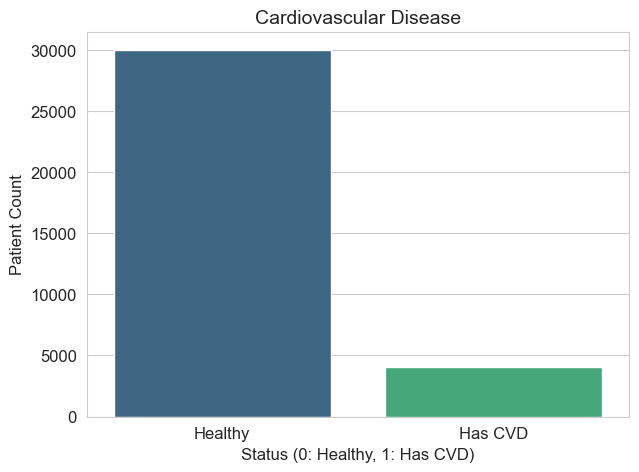


1.2 TARGET: Metabolic Syndrome Components (5 Labels)

High Waist Circumference:
  Normal (0): 11,810 (34.64%)
  Abnormal (1): 17,330 (50.83%)
  Missing: 4,957 (14.54%)


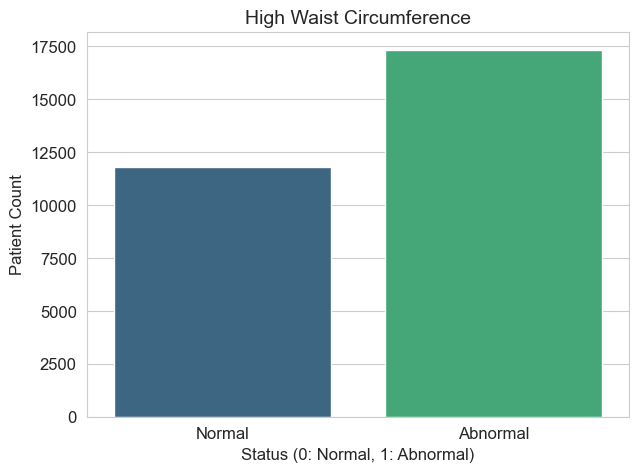


High Triglycerides Mg Dl:
  Normal (0): 11,228 (32.93%)
  Abnormal (1): 2,985 (8.75%)
  Missing: 19,884 (58.32%)


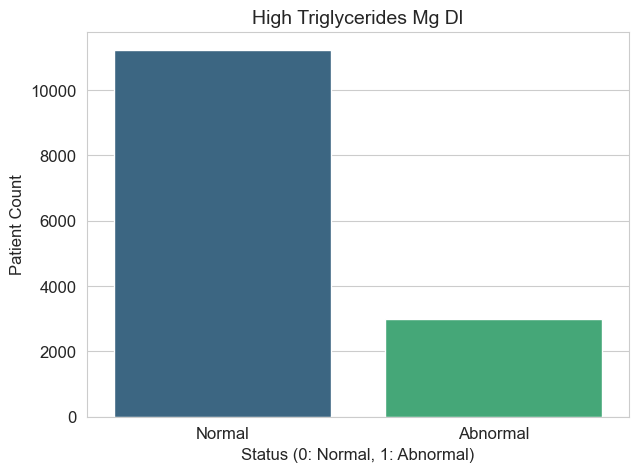


Low Hdl Mg Dl:
  Normal (0): 20,370 (59.74%)
  Abnormal (1): 8,485 (24.88%)
  Missing: 5,242 (15.37%)


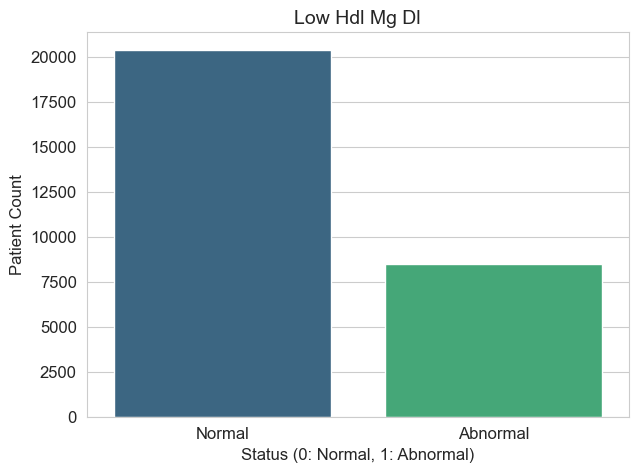


High Blood Pressure:
  Normal (0): 18,370 (53.88%)
  Abnormal (1): 10,328 (30.29%)
  Missing: 5,399 (15.83%)


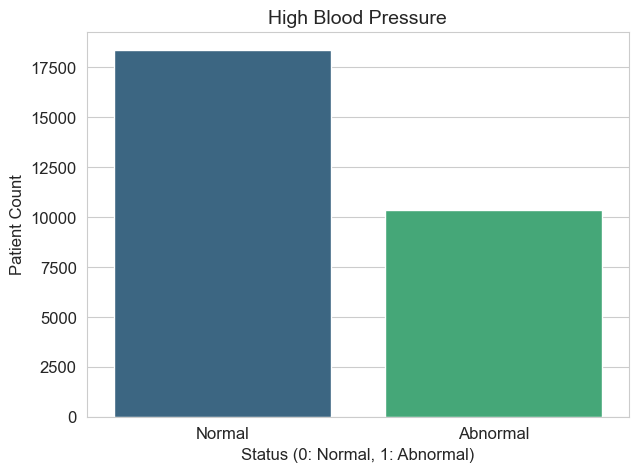


High Glucose Mg Dl:
  Normal (0): 5,687 (16.68%)
  Abnormal (1): 8,129 (23.84%)
  Missing: 20,281 (59.48%)


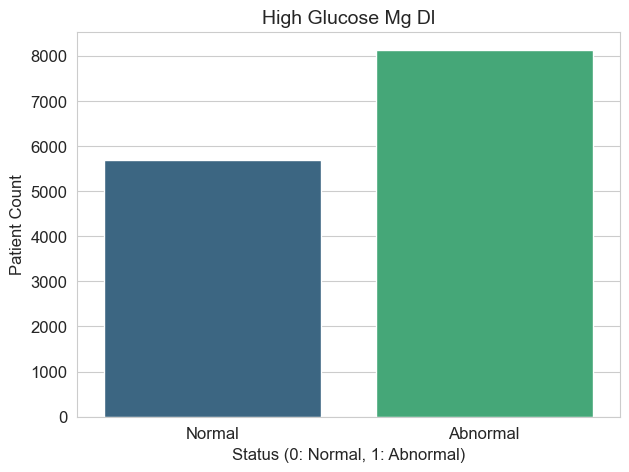


1.3 TARGET: Kidney Function (ACR Log)

1.4 TARGET: Liver Function (ALT Log)


In [4]:
# =========================================================
# 1. TARGET VARIABLE ANALYSIS
# =========================================================

# Helper function for binary classification targets
def analyze_binary_target(col_name, title, labels=('Normal', 'Abnormal')):
    """Analyze and visualize a binary target variable."""
    if col_name not in df.columns:
        return
    
    counts = df[col_name].value_counts(dropna=False)
    pct = df[col_name].value_counts(normalize=True, dropna=False) * 100
    missing = df[col_name].isnull().sum()
    
    print(f"\n{title}:")
    print(f"  {labels[0]} (0): {counts.get(0, 0):,} ({pct.get(0, 0):.2f}%)")
    print(f"  {labels[1]} (1): {counts.get(1, 0):,} ({pct.get(1, 0):.2f}%)")
    print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    plt.figure(figsize=(7, 5))
    sns.countplot(x=col_name, data=df, hue=col_name, palette='viridis', legend=False)
    plt.title(title, fontsize=14)
    plt.xlabel(f'Status (0: {labels[0]}, 1: {labels[1]})')
    plt.ylabel('Patient Count')
    plt.xticks([0, 1], labels, rotation=0)
    plt.show()

# Helper function for regression targets
def analyze_regression_target(col_name, title, color='steelblue'):
    """Analyze and visualize a regression target variable."""
    if col_name not in df.columns:
        return
    
    data = df[col_name].dropna()
    missing = df[col_name].isnull().sum()
    
    print(f"\n{title}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=50, color=color, alpha=0.7, edgecolor='black')
    plt.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    plt.axvline(data.median(), color='green', linestyle='-', label=f'Median: {data.median():.2f}')
    plt.title(f'{title} Distribution', fontsize=14)
    plt.xlabel(title.split('(')[0].strip() + ' (Log Scale)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 1.1 Cardiovascular Disease
print("="*80)
print("1.1 TARGET: Cardiovascular Disease")
print("="*80)
analyze_binary_target('has_cardiovascular_disease', 'Cardiovascular Disease', ('Healthy', 'Has CVD'))

# 1.2 Metabolic Syndrome Components
print("\n" + "="*80)
print("1.2 TARGET: Metabolic Syndrome Components (5 Labels)")
print("="*80)
metabolic_labels = [
    'high_waist_circumference',
    'high_triglycerides_mg_dl',
    'low_hdl_mg_dl',
    'high_blood_pressure',
    'high_glucose_mg_dl'
]

for label in metabolic_labels:
    analyze_binary_target(label, label.replace('_', ' ').title())

# 1.3 Kidney Function
print("\n" + "="*80)
print("1.3 TARGET: Kidney Function (ACR Log)")
print("="*80)
analyze_regression_target('kidney_acr_mg_g', 'Kidney Function (ACR Log)', 'steelblue')

# 1.4 Liver Function
print("\n" + "="*80)
print("1.4 TARGET: Liver Function (ALT Log)")
print("="*80)
analyze_regression_target('liver_alt_U_L', 'Liver Function (ALT Log)', 'coral')

2. NUMERICAL FEATURES: Descriptive Statistics

Analyzing 18 numerical variables:


,count,mean,std,min,25%,50%,75%,max
age,34097.0,51.158049,17.734500,20.00,36.00,52.00,66.00,80.00
income_ratio,29491.0,2.610263,1.638134,0.00,1.18,2.25,4.27,5.00
body_mass_index,30452.0,29.707668,7.343951,11.10,24.60,28.50,33.40,92.30
height_cm,30524.0,166.602780,10.118069,129.70,159.10,166.30,173.90,202.70
heart_rate_bpm,27475.0,71.328699,11.882017,34.00,63.00,70.00,78.00,160.00
white_blood_cells_count,29492.0,7.208328,2.210517,1.40,5.70,6.90,8.40,44.80
platelets_count,29492.0,244.006680,64.614821,36.00,200.00,237.00,280.00,787.00
hemoglobin_g_dl,29498.0,13.936070,1.541585,5.40,13.00,14.00,15.00,19.90
mean_corpuscular_volume_fL,29498.0,88.691949,6.060930,35.40,85.80,89.20,92.40,116.70
creatinine_mg_dl,28717.0,0.902683,0.480660,0.25,0.71,0.84,1.00,17.41


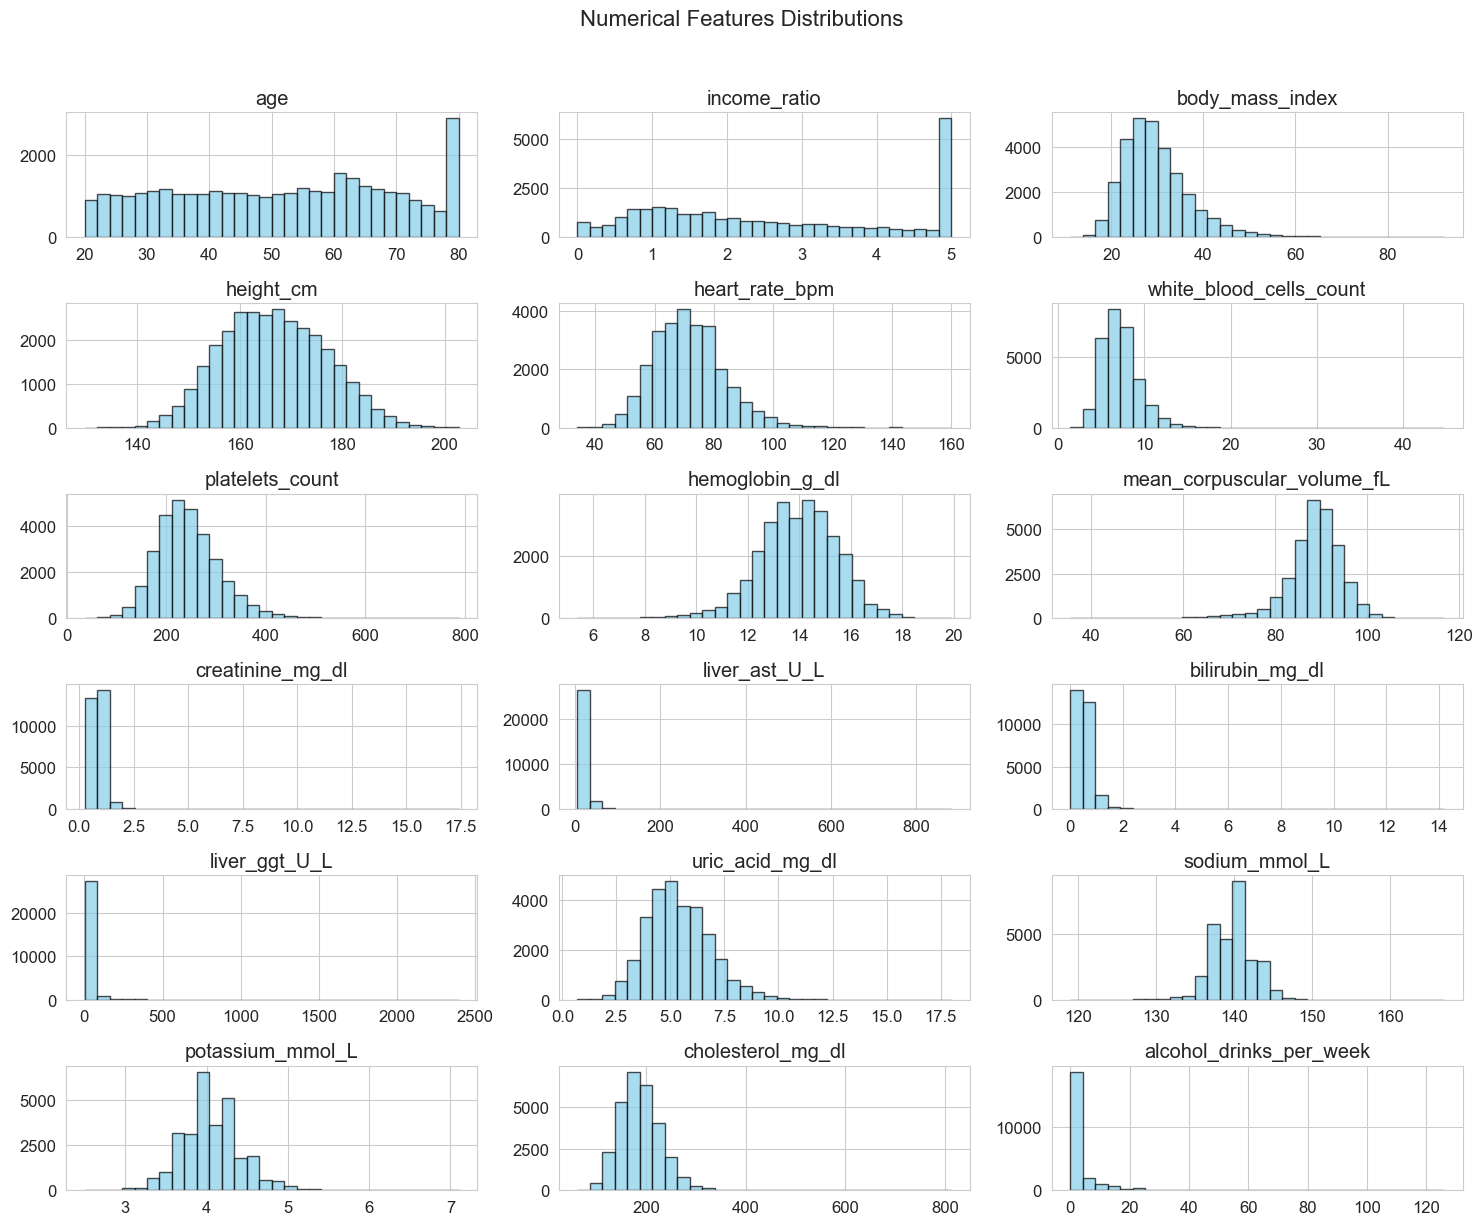

In [5]:
# =========================================================
# 2. NUMERICAL (CONTINUOUS) FEATURES ANALYSIS
# =========================================================

print("="*80)
print("2. NUMERICAL FEATURES: Descriptive Statistics")
print("="*80)

if len(numerical_cols) > 0:
    print(f"\nAnalyzing {len(numerical_cols)} numerical variables:")
    display(df[numerical_cols].describe().T)
    
    # Visualize all numerical features using pandas hist()
    df[numerical_cols].hist(bins=30, figsize=(15, 12), layout=(6, 3), 
                            color='skyblue', alpha=0.7, edgecolor='black')
    plt.suptitle('Numerical Features Distributions', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical variables found.")


3. CATEGORICAL FEATURES: Distribution Analysis

Analyzing 5 categorical variables:

gender:
  2.0: 17,924 (52.57%)
  1.0: 16,173 (47.43%)
  Missing: 0 (0.00%)


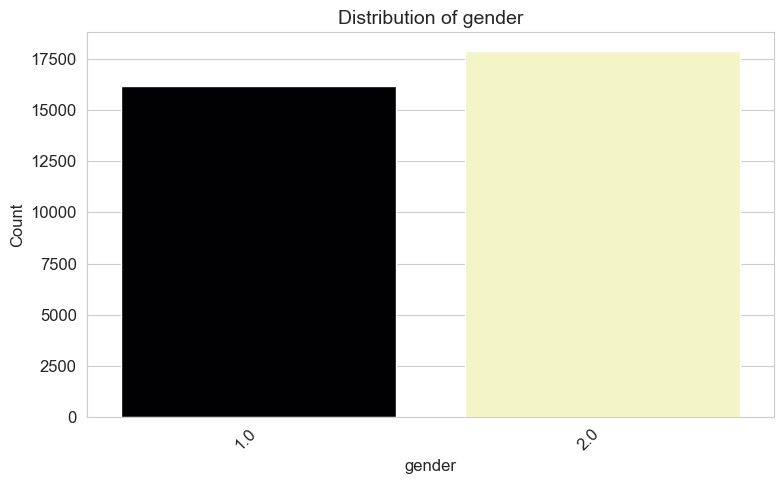


ethnicity:
  3.0: 14,042 (41.18%)
  4.0: 7,127 (20.90%)
  1.0: 4,099 (12.02%)
  6.0: 3,710 (10.88%)
  2.0: 3,512 (10.30%)
  7.0: 1,607 (4.71%)
  Missing: 0 (0.00%)


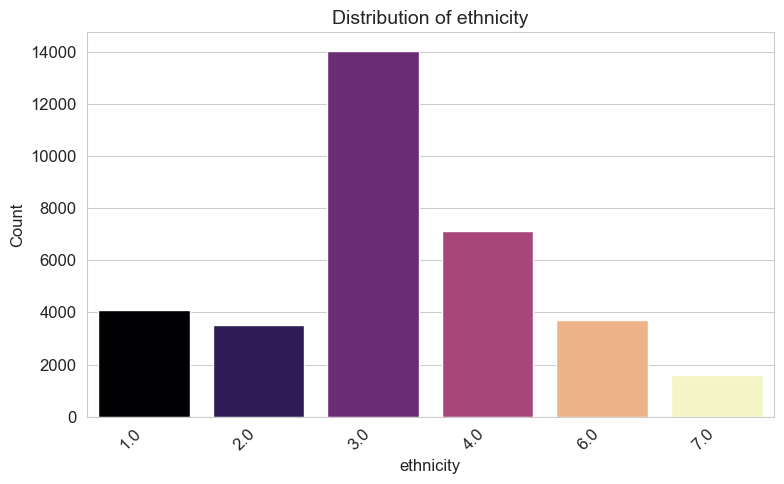


smoking_status:
  nan: 19,761 (57.96%)
  3.0: 8,227 (24.13%)
  1.0: 4,814 (14.12%)
  2.0: 1,295 (3.80%)
  Missing: 19,761 (57.96%)


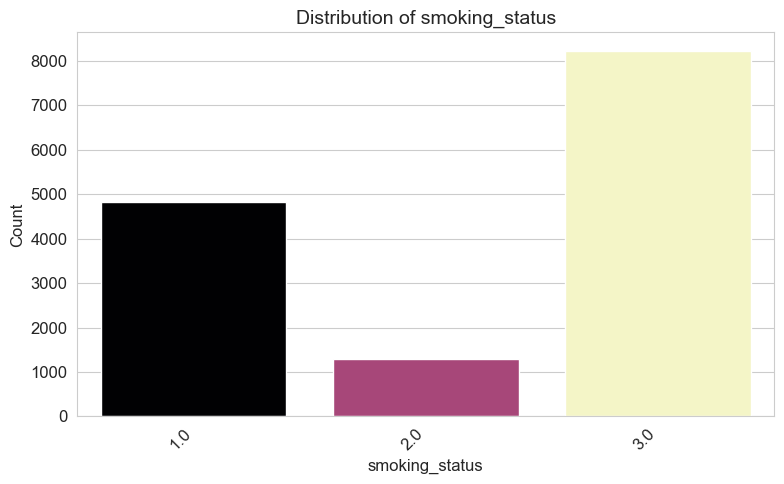


albuminuria_risk:
  0.0: 26,217 (76.89%)
  nan: 3,926 (11.51%)
  1.0: 3,265 (9.58%)
  2.0: 689 (2.02%)
  Missing: 3,926 (11.51%)


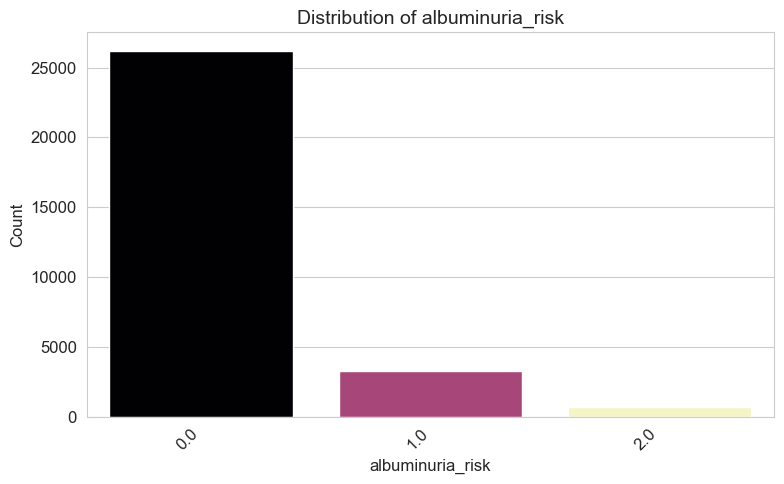


liver_dysfunction:
  0.0: 24,373 (71.48%)
  nan: 5,389 (15.80%)
  1.0: 4,335 (12.71%)
  Missing: 5,389 (15.80%)


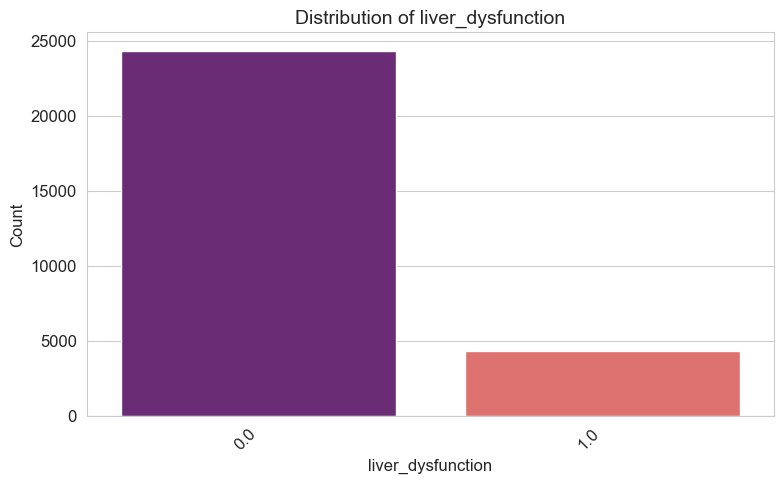

In [6]:
# =========================================================
# 3. CATEGORICAL FEATURES ANALYSIS
# =========================================================

print("="*80)
print("3. CATEGORICAL FEATURES: Distribution Analysis")
print("="*80)

if len(categorical_cols) > 0:
    print(f"\nAnalyzing {len(categorical_cols)} categorical variables:")
    
    for col in categorical_cols:
        counts = df[col].value_counts(dropna=False)
        pct = df[col].value_counts(normalize=True, dropna=False) * 100
        missing = df[col].isnull().sum()
        
        print(f"\n{col}:")
        for val, count in counts.items():
            print(f"  {val}: {count:,} ({pct[val]:.2f}%)")
        print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
        
        # Visualize if reasonable number of categories
        if counts.shape[0] <= 10:
            plt.figure(figsize=(8, 5))
            sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='magma', legend=False)
            plt.title(f'Distribution of {col}', fontsize=14)
            plt.ylabel('Count')
            plt.xlabel(col)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("No categorical variables found.")
